# Basic image anaylsis tutorial

This notebook documents basic (astronomical) image analysis with python.

In [1]:
# import the modules we need

from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from  astropy.visualization import make_lupton_rgb 
import matplotlib.pyplot as plt
from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip

Define where the image files are and what filters we have available

In [8]:

# the directory containing the images relative to this workbook 
image_dir = '../test_data/'

# list of filters 
filters = ['f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w']


Open the first image. The data is stored in a multi-extension FITS file. Essentially, in this case, the file contains three different image arrays:

- SCI: the science map, essentially a 2D array of the flux 
- ERR: the error map, an estimate of the error on every pixel
- WHT: the weight map

In [9]:

# open the i2d image file
hdul = fits.open(f"{image_dir}/{filters[0]}_i2d.fits")

# get info - 
hdul.info()


Filename: ../test_data//f115w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SCI           1 ImageHDU        39   (1000, 1000)   float32   
  2  ERR           1 ImageHDU        39   (1000, 1000)   float32   
  3  WHT           1 ImageHDU        39   (1000, 1000)   float32   


### Estimation of background noise

Background median= 0.0013320181460585445


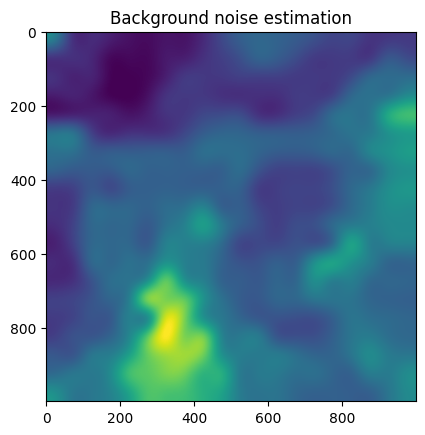

In [10]:
# grab the extension holding the science image
hdu = hdul['SCI']
bg_est=MedianBackground()
sig_clip=SigmaClip(sigma=3.0)
bg=Background2D(hdu.data,box_size=(50,50),filter_size=(3,3),bkg_estimator=bg_est,sigma_clip=sig_clip)
plt.imshow(bg.background)
plt.title("Background noise estimation")
print("Background median=",bg.background_median)



### Explore the science map

The science map is a map of the fluxes or intensity of light detected by every pixel through a cretain filter. A pixel with a large value means it is detecting more light. The colours on our map will be arbitrary meaning that the colours displayed are not the colour the pixel is detecting but is representative of the amount of light that pixel is recieving.

(1000, 1000)
XTENSION IMAGE
BITPIX -32
NAXIS 2
NAXIS1 1000
NAXIS2 1000
PCOUNT 0
GCOUNT 1
EXTNAME SCI
WCSAXES 2
CRPIX1 23179.5
CRPIX2 -1223.5
PC1_1 -0.64678977951046
PC1_2 -0.76266832969569
PC2_1 -0.76266832969569
PC2_2 0.64678977951046
CDELT1 8.3333333333333e-06
CDELT2 8.3333333333333e-06
CUNIT1 deg
CUNIT2 deg
CTYPE1 RA---TAN
CTYPE2 DEC--TAN
CRVAL1 214.825
CRVAL2 52.825
LONPOLE 180.0
LATPOLE 52.825
MJDREF 0.0
DATE-BEG 2022-06-21T18:09:46.649
MJD-BEG 59751.756789922
DATE-AVG 2022-06-21T19:19:05.420
MJD-AVG 59751.804923837
DATE-END 2022-06-21T20:27:34.055
MJD-END 59751.852477488
XPOSURE 49475.04
TELAPSE 49475.04
OBSGEO-X 362899179.14001
OBSGEO-Y -1339357702.7182
OBSGEO-Z -1035769565.0583
RADESYS ICRS
VELOSYS 14501.05


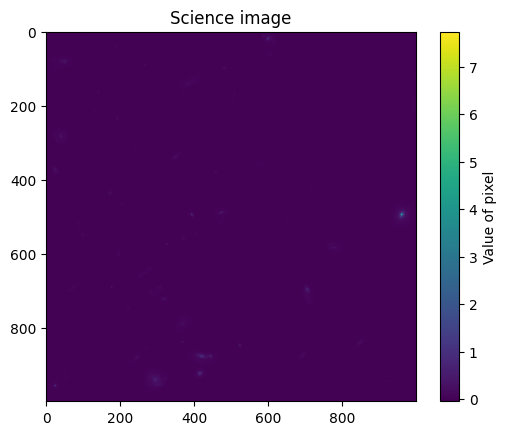

In [11]:

# grab the extension holding the science image
hdu = hdul['SCI']

# print the shape of the science image
print(hdu.data.shape)

# print the header keywords
for key, value in hdu.header.items():
    print(key, value)


#-Remove background noise-
sci_img=hdu.data-bg.background

# plot the data
plt.imshow(sci_img)
plt.title("Science image")
clb=plt.colorbar()
clb.set_label("Value of pixel")

plt.show()


The colours in this image are arbitrary. 

### Making the RGB image
Now making a colour image using filters corresponding to RGB colour values. Here we will pick 3 science maps that will each reperesent the intensity for Red, Green and Blue (RGB) for that pixel. This means each pixel will have 3 values and then can be converted to an RGB image.

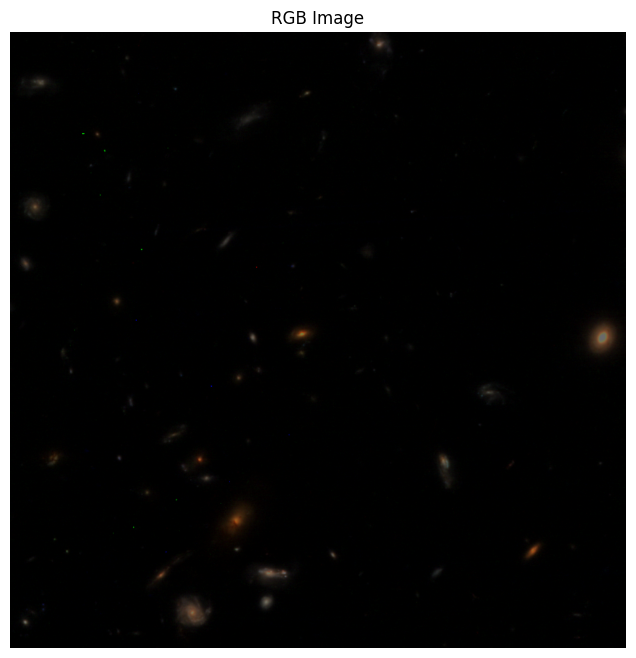

In [12]:


#-Setting up variables-
RGB=['f200w','f150w','f115w'] #These are will be the filters we will use to represent RGB colours respectively.
RGB_maps=[] # A list to contain the three RGB maps.
WT=[1,1,1] #This will allow the adjustment of the colour levels if needed.
Brightness=1 #Will just allow for brightness adjustment of image
bg_upper_lim=1000 #Multiple of background noise as a limit for pixel values.

#-Extracting data-
counter=0
for n in range(len(RGB)): #Looping over the fiters and extracting the data for the colours.
    temp=fits.open(f"{image_dir}/{RGB[counter]}_i2d.fits")
    temp_data=temp["SCI"].data

    #Estimating background for each map
    bg_est=MedianBackground()
    sig_clip=SigmaClip(sigma=3.0)
    bg=Background2D(hdu.data,box_size=(50,50),filter_size=(3,3),bkg_estimator=bg_est,sigma_clip=sig_clip)
    
    temp_data_fin=temp["SCI"].data-bg.background # Subtracting background from each flter and adding to our final list.
    temp_data_fin[temp_data_fin<0.0]=0#Exclude negative pixels
    temp_data_fin[temp_data_fin>bg.background_median*bg_upper_lim]=bg.background_median*bg_upper_lim

    RGB_maps.append(temp_data_fin)
    counter=counter+1
   

#-Making RGB image-
#Next we will be combing all our 3 maps together to create our final RGB image.
img=make_lupton_rgb(image_r=RGB_maps[0]*WT[0],image_g=RGB_maps[1]*WT[1],image_b=RGB_maps[2]*WT[2],minimum=0,stretch=1) 




#-Plotting the image-
fig1,ax1=plt.subplots(1,1,figsize=(8,8)) #Setting up the image space
img=img*Brightness  #Adjusting for brightness for visual clarity if needed.
ax1.imshow(img,vmax=0.5)
ax1.set_title("RGB Image")
ax1.set_axis_off()
plt.savefig("../Images/RGB Image.png")

plt.show()

